<a href="https://colab.research.google.com/github/DeshpandeVedant37/first-cure/blob/main/first_cure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gradio --quiet

import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image as keras_image

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from collections import Counter

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Path to dataset files:", path)
print("Files available:", os.listdir(path))

Using Colab cache for faster access to the 'skin-cancer-mnist-ham10000' dataset.
Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000
Files available: ['hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'HAM10000_images_part_1', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'HAM10000_metadata.csv']


In [ ]:
BASE_DIR = path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS_FROZEN = 10
EPOCHS_FINETUNE = 15

CLASS_NAMES = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
CANCER_CLASSES = ['mel', 'bcc', 'akiec']

CLASS_DISPLAY = {
    'akiec': 'Actinic Keratosis',
    'bcc':   'Basal Cell Carcinoma',
    'bkl':   'Benign Keratosis',
    'df':    'Dermatofibroma',
    'mel':   'Melanoma',
    'nv':    'Melanocytic Nevi',
    'vasc':  'Vascular Lesion'
}

tf.random.set_seed(SEED)
np.random.seed(SEED)

Dataset shape: (10015, 7)

Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


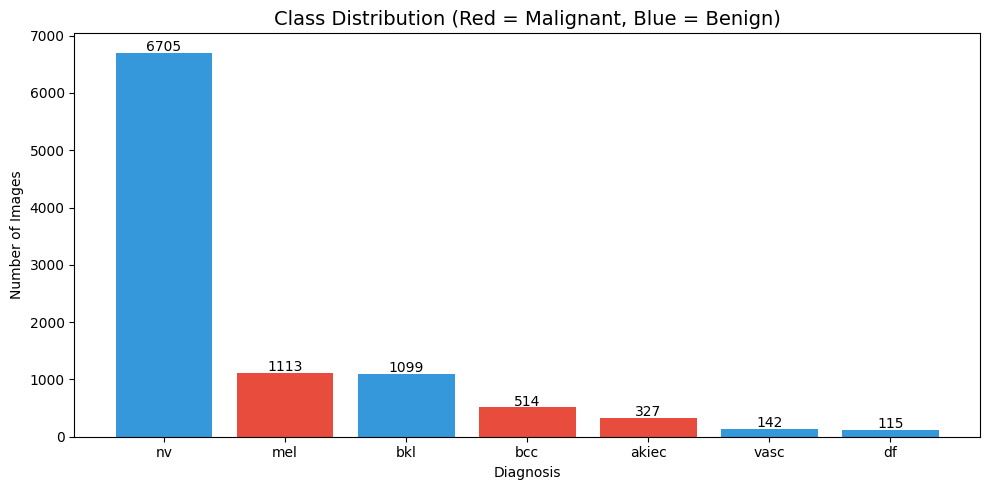

In [ ]:
metadata = pd.read_csv(os.path.join(BASE_DIR, "HAM10000_metadata.csv"))
print("Dataset shape:", metadata.shape)
print("\nClass distribution:")
print(metadata['dx'].value_counts())

plt.figure(figsize=(10, 5))
counts = metadata['dx'].value_counts()
colors = ['#e74c3c' if c in CANCER_CLASSES else '#3498db' for c in counts.index]
bars = plt.bar(counts.index, counts.values, color=colors)
plt.title('Class Distribution (Red = Malignant, Blue = Benign)', fontsize=14)
plt.xlabel('Diagnosis')
plt.ylabel('Number of Images')
for bar, val in zip(bars, counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30,
             str(val), ha='center', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
def find_image_path(image_id, base_dir):
    for folder in ["HAM10000_images_part_1", "HAM10000_images_part_2"]:
        full_path = os.path.join(base_dir, folder, image_id + ".jpg")
        if os.path.exists(full_path):
            return full_path
    return None

metadata['path'] = metadata['image_id'].apply(lambda x: find_image_path(x, BASE_DIR))
missing = metadata['path'].isna().sum()
print(f"Missing images: {missing}")
metadata = metadata.dropna(subset=['path']).reset_index(drop=True)
print(f"Total usable images: {len(metadata)}")

Missing images: 0
Total usable images: 10015


In [ ]:
unique_lesions = metadata['lesion_id'].unique()
train_lesions, val_lesions = train_test_split(
    unique_lesions, test_size=0.2, random_state=SEED
)

train_df = metadata[metadata['lesion_id'].isin(train_lesions)].reset_index(drop=True)
val_df   = metadata[metadata['lesion_id'].isin(val_lesions)].reset_index(drop=True)

print(f"Training samples:   {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples:   7974
Validation samples: 2041


In [ ]:
from collections import Counter

TARGET_PER_CLASS = 1500  # controls speed vs accuracy tradeoff

class_counts = Counter(train_df['dx'])

oversampled_dfs = []
for class_name, count in class_counts.items():
    class_subset = train_df[train_df['dx'] == class_name]
    oversampled = class_subset.sample(TARGET_PER_CLASS, replace=True, random_state=SEED)
    oversampled_dfs.append(oversampled)

train_df_balanced = pd.concat(oversampled_dfs).sample(frac=1, random_state=SEED).reset_index(drop=True)
print(f"Total training samples: {len(train_df_balanced)}")
print(train_df_balanced['dx'].value_counts())

Total training samples: 10500
dx
mel      1500
bcc      1500
vasc     1500
df       1500
nv       1500
akiec    1500
bkl      1500
Name: count, dtype: int64


In [ ]:
class_indices = {cls: i for i, cls in enumerate(sorted(CLASS_NAMES))}
index_to_class = {v: k for k, v in class_indices.items()}

y_train = train_df_balanced['dx'].map(class_indices).values

raw_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(CLASS_NAMES)),
    y=y_train
)
class_weight_dict = dict(enumerate(raw_weights))

class_weight_dict[class_indices['mel']]   *= 1.8
class_weight_dict[class_indices['akiec']] *= 1.5
class_weight_dict[class_indices['df']]    *= 1.3

print("Class weights:")
for idx, weight in class_weight_dict.items():
    print(f"  {index_to_class[idx]:6s}: {weight:.3f}")


Class weights:
  akiec : 1.500
  bcc   : 1.000
  bkl   : 1.000
  df    : 1.300
  mel   : 1.800
  nv    : 1.000
  vasc  : 1.000


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=20.0,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df_balanced,
    x_col="path",
    y_col="dx",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="path",
    y_col="dx",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Training samples:  ", train_generator.n)
print("Validation samples:", val_generator.n)
print("Class mapping:", train_generator.class_indices)

Found 10500 validated image filenames belonging to 7 classes.
Found 2041 validated image filenames belonging to 7 classes.
Training samples:   10500
Validation samples: 2041
Class mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


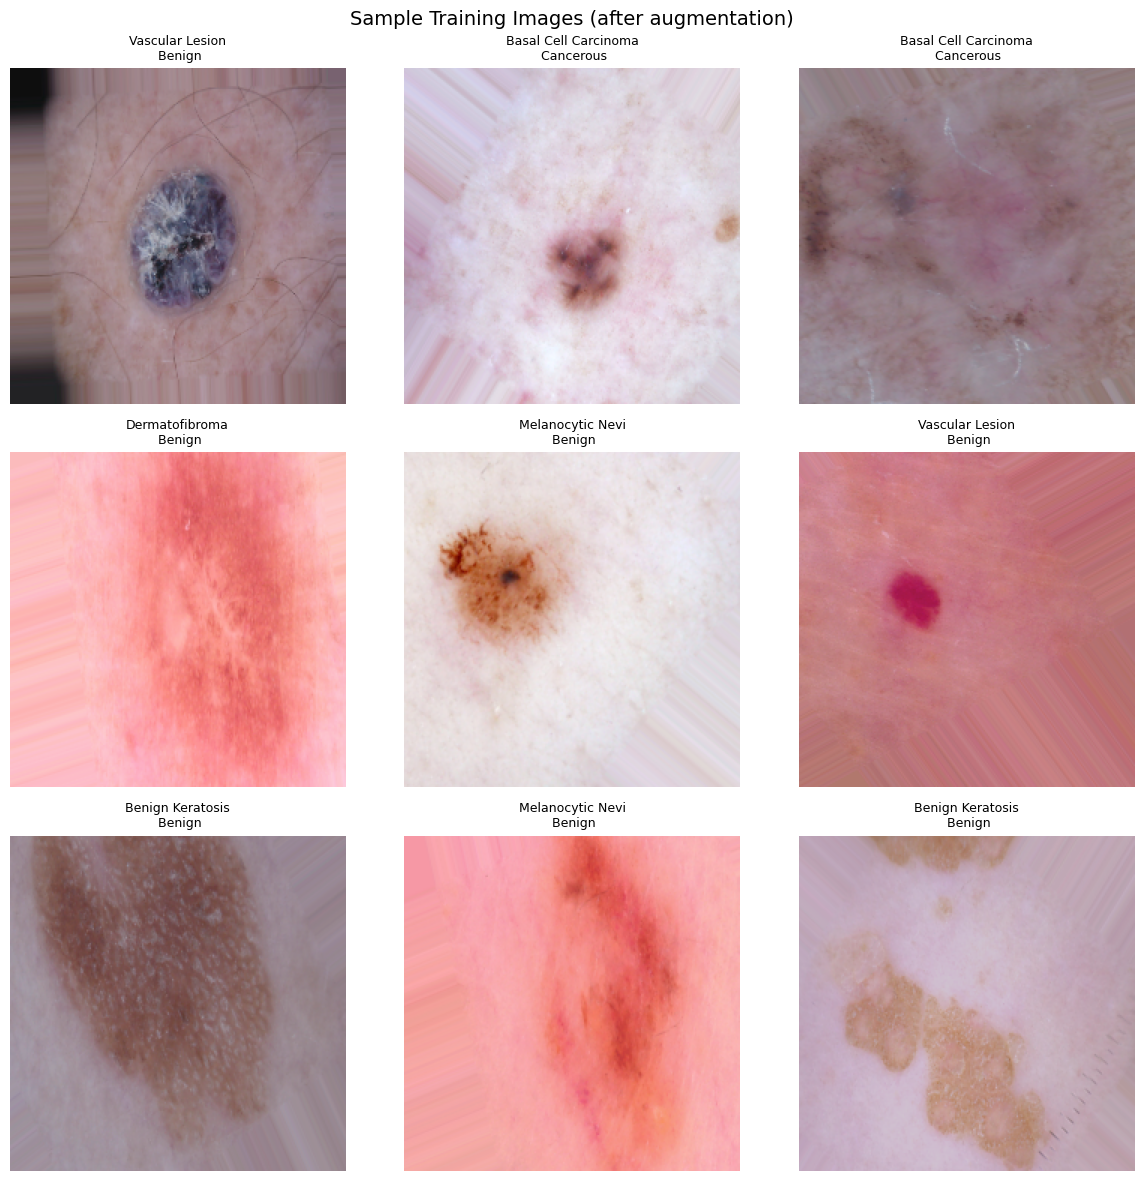

In [ ]:
  def plot_sample_images(generator, n=9):
      batch_images, batch_labels = next(generator)
      idx_to_class = {v: k for k, v in generator.class_indices.items()}

      plt.figure(figsize=(12, 12))
      for i in range(min(n, len(batch_images))):
          plt.subplot(3, 3, i + 1)
          img_display = np.clip(batch_images[i], 0, 255).astype(np.uint8)
          plt.imshow(img_display)

          class_id = np.argmax(batch_labels[i])
          class_name = idx_to_class[class_id]
          label = ' Cancerous' if class_name in CANCER_CLASSES else ' Benign'
          display_name = CLASS_DISPLAY.get(class_name, class_name)

          plt.title(f"{display_name}\n{label}", fontsize=9)
          plt.axis('off')

      plt.suptitle('Sample Training Images (after augmentation)', fontsize=14)
      plt.tight_layout()
      plt.show()

  plot_sample_images(train_generator)

In [ ]:
def build_model(num_classes=7, freeze_base=True):
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)    # changed
    )
    base_model.trainable = not freeze_base

    inputs = tf.keras.Input(shape=(224, 224, 3))    # changed
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model, base_model

model, base_model = build_model(num_classes=7, freeze_base=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,216,950 (42.79 MB)

 Trainable params: 430,343 (1.64 MB)

 Non-trainable params: 10,786,607 (41.15 MB)

In [ ]:
callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_model_phase1.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("=" * 60)
print("PHASE 1: Training classification head (base frozen)")
print("=" * 60)

history1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FROZEN,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks_phase1,
    verbose=1
)

PHASE 1: Training classification head (base frozen)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 744ms/step - accuracy: 0.3115 - loss: 2.4904
Epoch 1: val_accuracy improved from -inf to 0.41567, saving model to best_model_phase1.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 329s 849ms/step - accuracy: 0.3116 - loss: 2.4892 - val_accuracy: 0.4157 - val_loss: 1.3711 - learning_rate: 0.0010
Epoch 2/10
  1/328 ━━━━━━━━━━━━━━━━━━━━ 28s 88ms/step - accuracy: 0.4375 - loss: 1.9716

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.41567
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4375 - loss: 1.9716 - val_accuracy: 0.4137 - val_loss: 1.3652 - learning_rate: 0.0010
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4816 - loss: 1.6382
Epoch 3: val_accuracy improved from 0.41567 to 0.50546, saving model to best_model_phase1.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 216s 658ms/step - accuracy: 0.4816 - loss: 1.6381 - val_accuracy: 0.5055 - val_loss: 1.2161 - learning_rate: 0.0010
Epoch 4/10
  1/328 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.4375 - loss: 1.5576
Epoch 4: val_accuracy improved from 0.50546 to 0.51240, saving model to best_model_phase1.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.4375 - loss: 1.5576 - val_accuracy: 0.5124 - val_loss: 1.2089 - learning_rate: 0.0010
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.5224 - loss: 1.5385
Epoch 5: val_accuracy did not improve from 0.51240
328/328 ━━

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('best_model_final.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

print("=" * 60)
print("PHASE 2: Fine-tuning entire network (very low LR)")
print("=" * 60)

history2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS_FINETUNE,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=callbacks_phase2,
    verbose=1
)

PHASE 2: Fine-tuning entire network (very low LR)
Epoch 1/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - accuracy: 0.3724 - loss: 2.1037
Epoch 1: val_accuracy improved from -inf to 0.44940, saving model to best_model_final.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 442s 970ms/step - accuracy: 0.3725 - loss: 2.1032 - val_accuracy: 0.4494 - val_loss: 1.2686 - learning_rate: 1.0000e-05
Epoch 2/15
  1/328 ━━━━━━━━━━━━━━━━━━━━ 1:42 314ms/step - accuracy: 0.5625 - loss: 1.3511
Epoch 2: val_accuracy did not improve from 0.44940
328/328 ━━━━━━━━━━━━━━━━━━━━ 15s 46ms/step - accuracy: 0.5625 - loss: 1.3511 - val_accuracy: 0.4494 - val_loss: 1.2676 - learning_rate: 1.0000e-05
Epoch 3/15
328/328 ━━━━━━━━━━━━━━━━━━━━ 0s 696ms/step - accuracy: 0.4986 - loss: 1.6371
Epoch 3: val_accuracy improved from 0.44940 to 0.50546, saving model to best_model_final.keras
328/328 ━━━━━━━━━━━━━━━━━━━━ 246s 749ms/step - accuracy: 0.4987 - loss: 1.6369 - val_accuracy: 0.5055 - val_loss: 1.1581 - learning_rate: 1.0000e-05
E

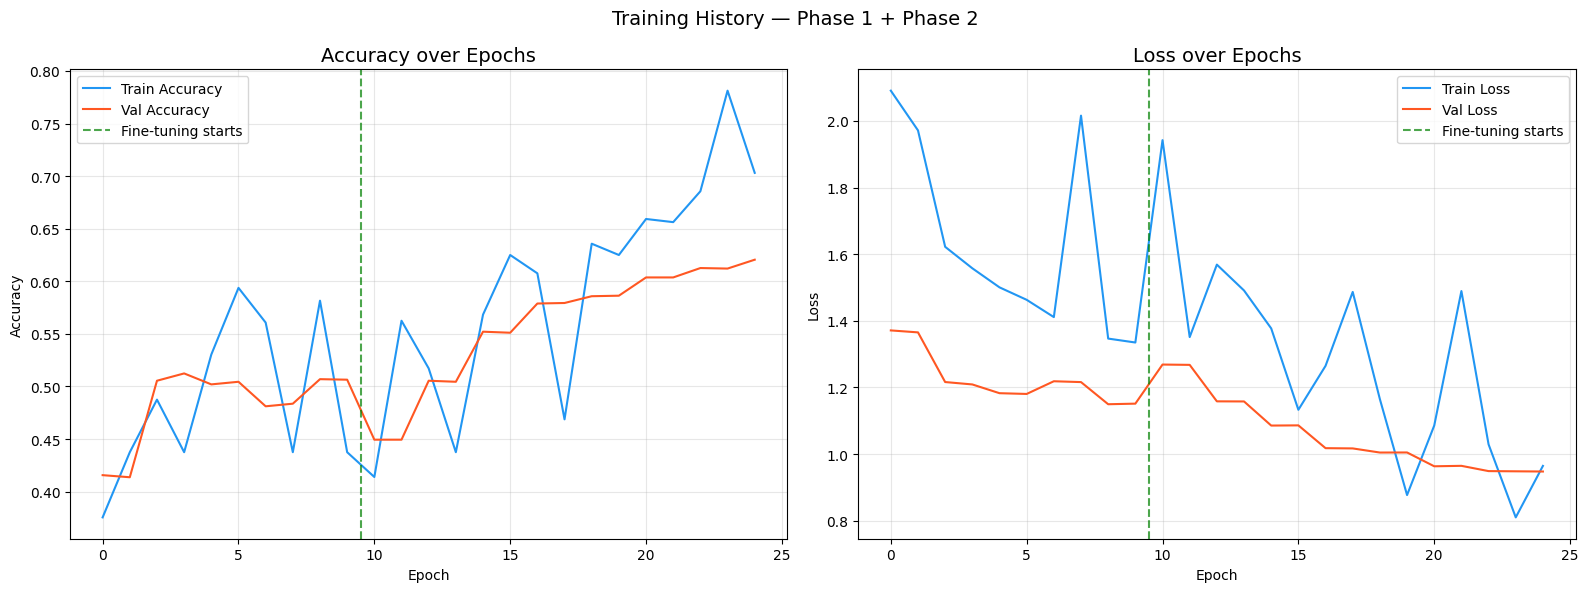

In [ ]:
def merge_histories(h1, h2):
    merged = {}
    for key in h1.history:
        merged[key] = h1.history[key] + h2.history.get(key, [])
    return merged

all_history = merge_histories(history1, history2)
phase1_len = len(history1.history['accuracy'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(all_history['accuracy'], label='Train Accuracy', color='#2196F3')
axes[0].plot(all_history['val_accuracy'], label='Val Accuracy', color='#FF5722')
axes[0].axvline(x=phase1_len - 0.5, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
axes[0].set_title('Accuracy over Epochs', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(all_history['loss'], label='Train Loss', color='#2196F3')
axes[1].plot(all_history['val_loss'], label='Val Loss', color='#FF5722')
axes[1].axvline(x=phase1_len - 0.5, color='green', linestyle='--', alpha=0.7, label='Fine-tuning starts')
axes[1].set_title('Loss over Epochs', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.suptitle('Training History — Phase 1 + Phase 2', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
val_generator.reset()
print("Running predictions on validation set...")
preds = model.predict(val_generator, steps=val_generator.samples // BATCH_SIZE + 1, verbose=1)

pred_classes = np.argmax(preds, axis=1)
true_classes = val_generator.classes[:len(pred_classes)]
class_labels = [index_to_class[i] for i in range(len(CLASS_NAMES))]

overall_acc = np.mean(pred_classes == true_classes)
balanced_acc = balanced_accuracy_score(true_classes, pred_classes)

print(f"\n{'='*50}")
print(f"Overall Accuracy:  {overall_acc*100:.2f}%")
print(f"Balanced Accuracy: {balanced_acc*100:.2f}%")
print(f"{'='*50}")
print("\n📋 Per-class Report:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

Running predictions on validation set...
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 508ms/step

Overall Accuracy:  61.49%
Balanced Accuracy: 60.22%

📋 Per-class Report:
              precision    recall  f1-score   support

       akiec       0.36      0.22      0.27        68
         bcc       0.78      0.48      0.59       132
         bkl       0.47      0.62      0.53       244
          df       0.25      0.71      0.37        34
         mel       0.26      0.68      0.38       225
          nv       0.96      0.63      0.76      1302
        vasc       0.50      0.89      0.64        36

    accuracy                           0.61      2041
   macro avg       0.51      0.60      0.51      2041
weighted avg       0.77      0.61      0.65      2041



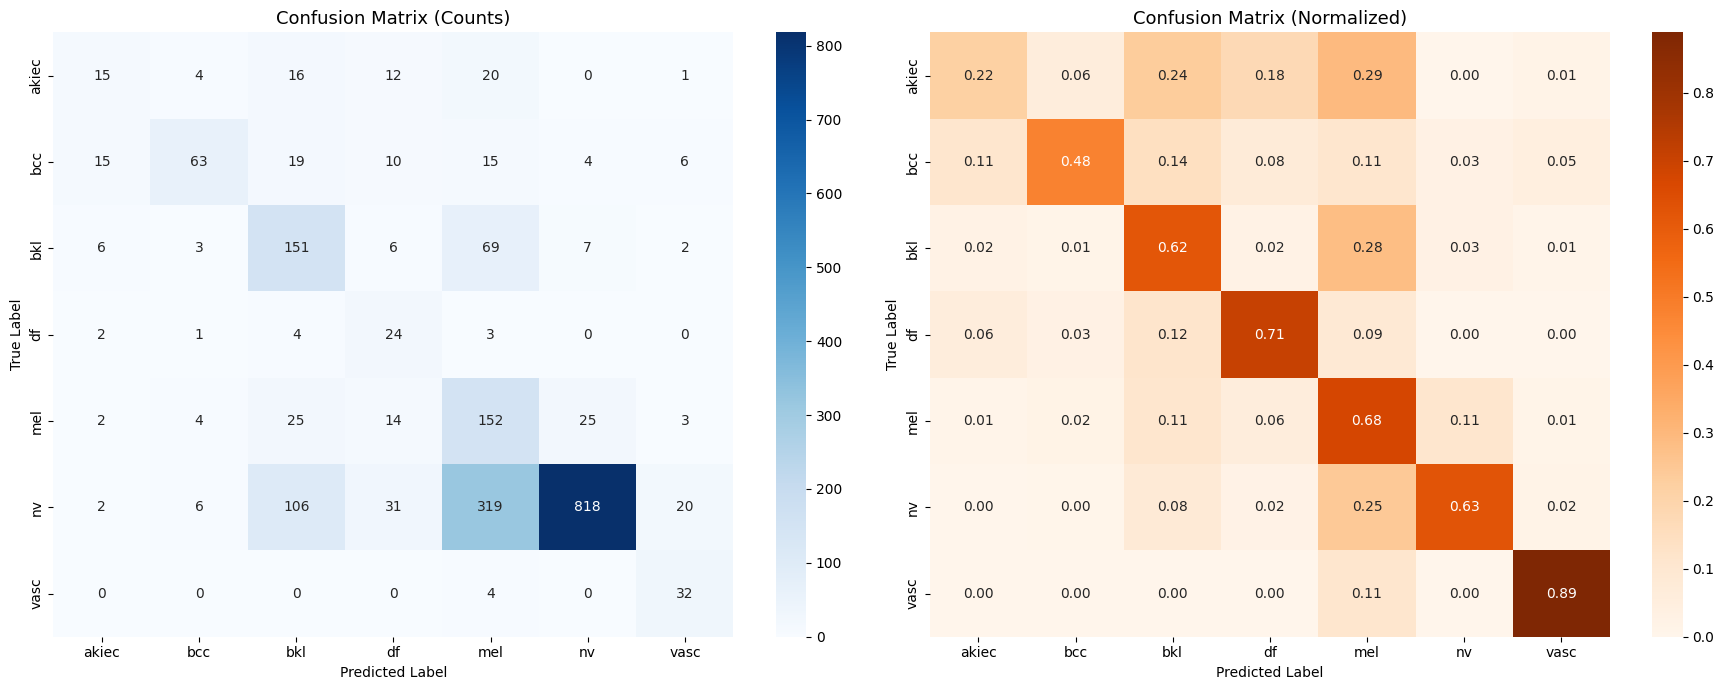

In [ ]:
cm = confusion_matrix(true_classes, pred_classes)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=13)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Oranges',
            xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=13)
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [ ]:
import json

model.save("ham10000_efficientnetB3_final.keras")
print(" Model saved")

with open("class_mapping.json", "w") as f:
    json.dump({
        "class_indices": class_indices,
        "cancer_classes": CANCER_CLASSES,
        "class_display": CLASS_DISPLAY
    }, f, indent=2)
print("Class mapping saved")

# Check file size
size_mb = os.path.getsize("ham10000_efficientnetB3_final.keras") / 1024 / 1024
print(f" Model size: {size_mb:.1f} MB")

 Model saved
Class mapping saved
 Model size: 129.2 MB


In [ ]:
!pip install pyngrok --quiet

import gradio as gr
import numpy as np
import threading
import time
from pyngrok import ngrok
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.efficientnet import preprocess_input

# ── Kill any existing instances ──────────────────────────────────────
ngrok.kill()
try:
    demo.close()
except:
    pass
time.sleep(2)

# ── Prediction function ──────────────────────────────────────────────
def predict(uploaded_image):
    if uploaded_image is None:
        return "Please upload an image.", {}

    img = uploaded_image.resize((224, 224))
    img_array = keras_image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    preds = model.predict(img_array, verbose=0)[0]
    pred_index = np.argmax(preds)
    pred_class = index_to_class[pred_index]
    confidence = float(preds[pred_index])
    is_cancerous = pred_class in CANCER_CLASSES
    display_name = CLASS_DISPLAY.get(pred_class, pred_class)
    risk = "🔴 HIGH RISK — Consult a dermatologist" if is_cancerous else "🟢 LOW RISK — Monitor for changes"

    label = f"{display_name}\nConfidence: {confidence*100:.1f}%\n{risk}"
    confidences = {
        CLASS_DISPLAY.get(index_to_class[i], index_to_class[i]): float(preds[i])
        for i in range(len(preds))
    }

    return label, confidences


# ── Build Gradio app ─────────────────────────────────────────────────
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload Skin Lesion Image"),
    outputs=[
        gr.Textbox(label="Prediction & Risk Level"),
        gr.Label(num_top_classes=7, label="Confidence per Class")
    ],
    title="🔬 Skin Cancer Detection",
    description="Upload a dermoscopic image to classify the skin lesion.\n⚠️ For research purposes only — not a substitute for medical diagnosis.",
    theme=gr.themes.Soft(),
    flagging_mode="never"
)


# ── Launch via ngrok ─────────────────────────────────────────────────
ngrok.set_auth_token("39yZxkSzAApvp32eY9EM0YYItjz_2v1AV9jLFiAMXGBSBoLKf")  # ← replace this

def run():
    demo.launch(server_port=7862, share=False, quiet=True)

t = threading.Thread(target=run, daemon=True)
t.start()
time.sleep(5)  # wait for server to fully start

public_url = ngrok.connect(7862)
print(f"\n✅ Your app is live at: {public_url}")
print("Share this link with judges!")

<IPython.core.display.Javascript object>


✅ Your app is live at: NgrokTunnel: "https://magnetometric-camden-unlined.ngrok-free.dev" -> "http://localhost:7862"
Share this link with judges!


In [ ]:
from google.colab import files
files.download("best_model_final.keras")
files.download("class_mapping.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
print(os.path.exists("best_model_final.keras"))
print(os.path.exists("best_model_phase1.keras"))
print(os.listdir("."))

True
True
['.config', '.gradio', 'class_mapping.json', 'best_model_phase1.keras', 'scan_history.json', 'best_model_final.keras', 'ham10000_efficientnetB3_final.keras', 'sample_data']
